In [2]:
# ==========================================
# CELL 1: Install & Import Libraries
# ==========================================
!pip install yfinance -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visualization style
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

print("Libraries installed and imported successfully!")

# ==========================================
# CELL 2: Load Price Data (Yahoo Finance)
# ==========================================
# Define the ticker (Bitcoin-USD)
ticker = "BTC-USD"

# Define the Date Range (Matches your Project Description)
start_date = "2019-01-01"
end_date = datetime.now().strftime('%Y-%m-%d') # Up to today

# Download Data
print(f"Downloading data for {ticker} from {start_date} to {end_date}...")
df_price = yf.download(ticker, start=start_date, end=end_date)

# Clean up the dataframe (Yahoo sometimes creates MultiIndex columns)
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.droplevel(1)

# Reset index so 'Date' is a proper column
df_price.reset_index(inplace=True)

# Preview
print(f"Data Loaded! Shape: {df_price.shape}")
df_price.head()

/tmp/ipython-input-3698871821.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Libraries installed and imported successfully!
Data Loaded! Shape: (2554, 6)


Price,Date,Close,High,Low,Open,Volume
0,2019-01-01,3843.520020,3850.913818,3707.231201,3746.713379,4324200990
1,2019-01-02,3943.409424,3947.981201,3817.409424,3849.216309,5244856836
2,2019-01-03,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
3,2019-01-04,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
4,2019-01-05,3845.194580,3904.903076,3836.900146,3851.973877,5137609824


In [3]:
# ==========================================
# CELL 3: Fetch Blockchain Metrics (Free Sources)
# ==========================================
import requests

def get_blockchain_data(chart_name):
    """
    Fetches historical data from Blockchain.com public API
    charts: 'hash-rate', 'n-unique-addresses' (Active Addresses)
    """
    url = f"https://api.blockchain.info/charts/{chart_name}?timespan=all&format=json"
    try:
        response = requests.get(url)
        data = response.json()

        # Parse into a DataFrame
        df = pd.DataFrame(data['values'])
        df.columns = ['Timestamp', chart_name]

        # Convert Timestamp to Date
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
        df.drop('Timestamp', axis=1, inplace=True)

        # Set Date as Index to resample (ensure daily freq)
        df.set_index('Date', inplace=True)
        df = df.resample('D').mean() # Ensure we have 1 row per day
        return df
    except Exception as e:
        print(f"Error fetching {chart_name}: {e}")
        return None

print("Fetching Hash Rate...")
df_hash = get_blockchain_data('hash-rate')

print("Fetching Active Addresses...")
df_addr = get_blockchain_data('n-unique-addresses')

# Merge with our Price Data
# First, ensure df_price has Date as index for merging
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)

# Merge Hash Rate
if df_hash is not None:
    df_merged = df_price.join(df_hash, how='inner')
    # Rename column for clarity
    df_merged.rename(columns={'hash-rate': 'Hash_Rate'}, inplace=True)

# Merge Active Addresses
if df_addr is not None:
    df_merged = df_merged.join(df_addr, how='inner')
    df_merged.rename(columns={'n-unique-addresses': 'Active_Addr'}, inplace=True)

# Reset Index to make Date a column again (clean look)
df_merged.reset_index(inplace=True)

print("\nSUCCESS! Merged Dataset Preview:")
print(df_merged[['Date', 'Close', 'Hash_Rate', 'Active_Addr']].tail())

# Check for missing values
print("\nMissing Values Count:")
print(df_merged.isnull().sum())

Fetching Hash Rate...
Fetching Active Addresses...

SUCCESS! Merged Dataset Preview:
           Date         Close     Hash_Rate  Active_Addr
2546 2025-12-21  88621.750000           NaN     436144.0
2547 2025-12-22  88490.015625           NaN          NaN
2548 2025-12-23  87414.000000           NaN          NaN
2549 2025-12-24  87611.960938  1.171326e+09          NaN
2550 2025-12-25  87234.742188           NaN     431619.0

Missing Values Count:
Date              0
Close             0
High              0
Low               0
Open              0
Volume            0
Hash_Rate      1914
Active_Addr    1914
dtype: int64


Missing values after interpolation:
Date           0
Close          0
High           0
Low            0
Open           0
Volume         0
Hash_Rate      0
Active_Addr    0
dtype: int64

Final Dataset Shape: (2521, 12)
------------------------------
           Date         Close          High           Low          Open  \
2546 2025-12-21  88621.750000  89027.953125  87613.203125  88344.703125   
2547 2025-12-22  88490.015625  90501.929688  87908.070312  88621.398438   
2548 2025-12-23  87414.000000  88898.382812  86606.976562  88490.031250   
2549 2025-12-24  87611.960938  87956.882812  86411.796875  87404.320312   
2550 2025-12-25  87234.742188  88501.789062  86949.257812  87608.320312   

           Volume     Hash_Rate  Active_Addr  Log_Return  Volatility  \
2546  19845522660  1.105024e+09    436144.00    0.003139    0.021491   
2547  38047472118  1.127125e+09    435012.75   -0.001488    0.021462   
2548  43683011533  1.149225e+09    433881.50   -0.012234    0.021123   
2549  255502

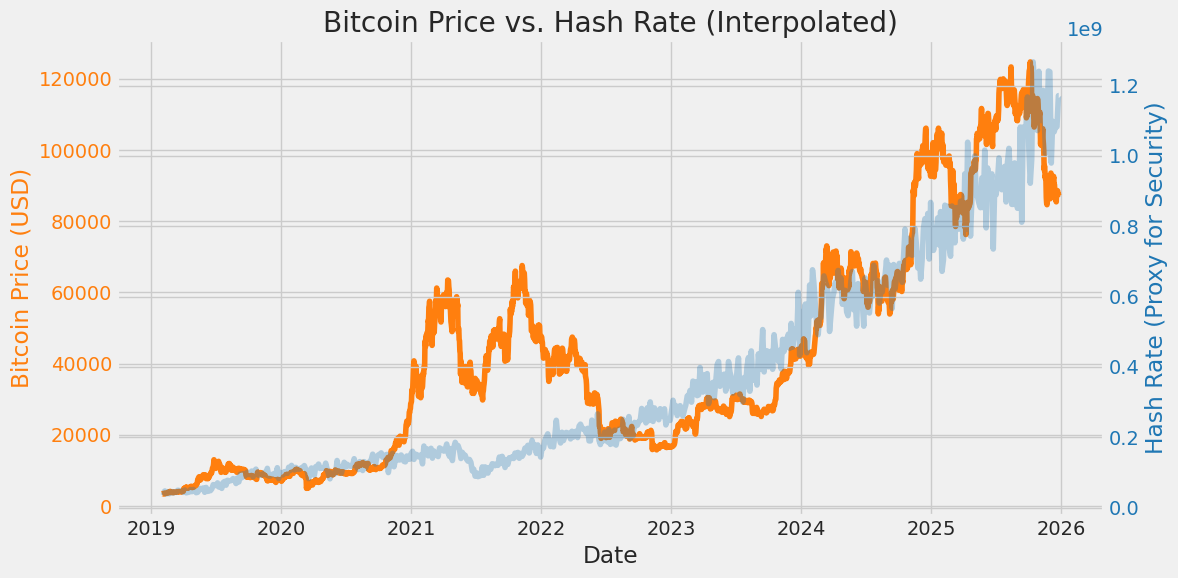

In [4]:
# ==========================================
# CELL 4: Data Cleaning & Feature Engineering
# ==========================================

# 1. FIX MISSING VALUES (Linear Interpolation)
# We limit direction='both' to catch start/end gaps if reasonable
df_clean = df_merged.interpolate(method='linear', limit_direction='both')

# Check if it worked
print(f"Missing values after interpolation:\n{df_clean.isnull().sum()}")

# 2. FEATURE ENGINEERING (Creating the inputs for LSTM)
# Calculate Log Returns (Stationary Time Series)
df_clean['Log_Return'] = np.log(df_clean['Close'] / df_clean['Close'].shift(1))

# Calculate Rolling Volatility (30-day standard deviation of returns)
# This matches your PDF description
df_clean['Volatility'] = df_clean['Log_Return'].rolling(window=30).std()

# Calculate Moving Averages (Trend Indicators)
df_clean['MA_7'] = df_clean['Close'].rolling(window=7).mean()
df_clean['MA_30'] = df_clean['Close'].rolling(window=30).mean()

# 3. FINAL CLEANUP
# The rolling windows create NaNs at the very start (first 30 days)
# We must drop these rows to have a clean dataset
df_final = df_clean.dropna()

print(f"\nFinal Dataset Shape: {df_final.shape}")
print("-" * 30)
print(df_final.tail())

# 4. VISUALIZATION (Sanity Check)
# Plot Price vs Hash Rate to see if they align
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(df_final['Date'], df_final['Close'], color=color, label='Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Hash Rate (Proxy for Security)', color=color)
ax2.plot(df_final['Date'], df_final['Hash_Rate'], color=color, alpha=0.3, label='Hash Rate')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Bitcoin Price vs. Hash Rate (Interpolated)')
fig.tight_layout()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 25.6 MB/s eta 0:00:00
Generating GARCH Volatility Features...


/tmp/ipython-input-147564665.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['GARCH_Vol'] = garch_fit.conditional_volatility


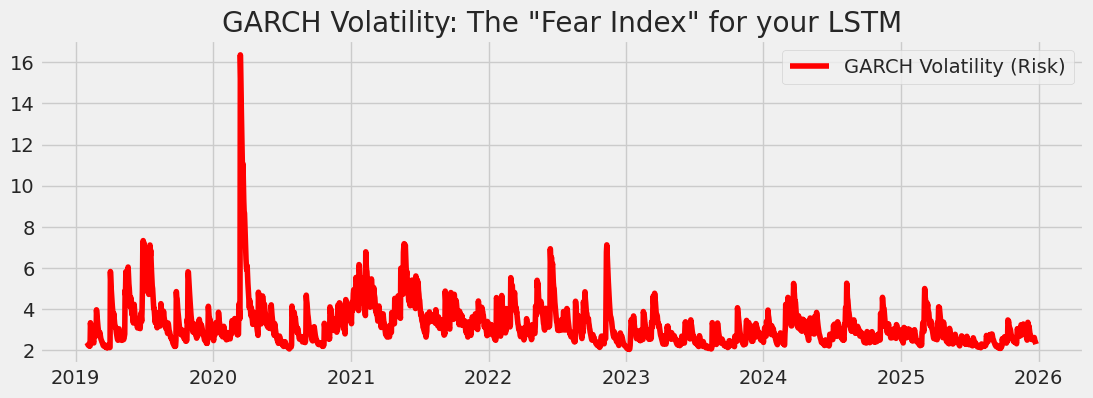

New Dataset Head (with GARCH):
           Date         Close  Log_Return  GARCH_Vol
2546 2025-12-21  88621.750000    0.003139   2.534266
2547 2025-12-22  88490.015625   -0.001488   2.451549
2548 2025-12-23  87414.000000   -0.012234   2.382529
2549 2025-12-24  87611.960938    0.002262   2.369849
2550 2025-12-25  87234.742188   -0.004315   2.310071


In [6]:
# ==========================================
# CELL 5: Hybrid Modeling - GARCH Feature Generation
# ==========================================
!pip install arch -q
from arch import arch_model

print("Generating GARCH Volatility Features...")

# 1. Fit GARCH(1,1) on the Returns
# We use 'Log_Return' * 100 because GARCH likes numbers > 1 (better convergence)
returns = df_final['Log_Return'] * 100

# Specify GARCH model (Standard GARCH)
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# 2. Get the Conditional Volatility (The "Risk" Metric)
df_final['GARCH_Vol'] = garch_fit.conditional_volatility

# 3. Visualization: Does GARCH catch the crashes?
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_final['Date'], df_final['GARCH_Vol'], color='red', label='GARCH Volatility (Risk)')
ax.set_title('GARCH Volatility: The "Fear Index" for your LSTM')
ax.legend()
plt.show()

# 4. Update the Feature List for LSTM
# Now your LSTM will learn from Price AND the "Fear Index"
print("New Dataset Head (with GARCH):")
print(df_final[['Date', 'Close', 'Log_Return', 'GARCH_Vol']].tail())

Training Shape: (1968, 60, 5) | Testing Shape: (493, 60, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting Training... (This might take a minute)
Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0144 - val_loss: 0.0044
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 9.9394e-04 - val_loss: 0.0053
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 9.5045e-04 - val_loss: 0.0051
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0010 - val_loss: 0.0064
Epoch 1

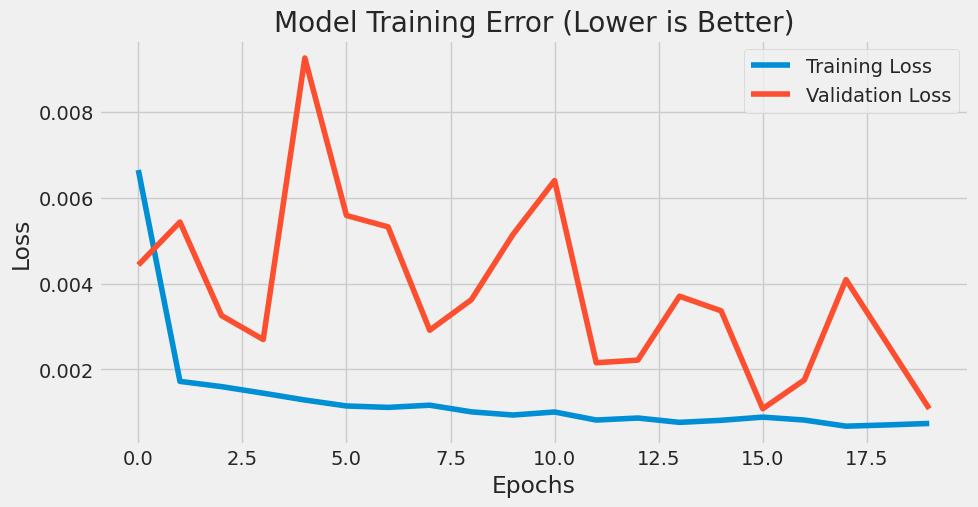

Training Complete!


In [7]:
# ==========================================
# CELL 6: Build & Train the Hybrid LSTM Model
# ==========================================
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. PREPARE THE DATA
# We will use these columns to predict the 'Close' price
feature_cols = ['Close', 'Log_Return', 'Hash_Rate', 'Active_Addr', 'GARCH_Vol']
target_col = 'Close'

# Scale the data (0 to 1) to make LSTM happy
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_final[feature_cols])

# Function to create sequences (Lookback Window)
def create_sequences(dataset, target_col_idx, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i])       # The past 60 days of ALL features
        y.append(dataset[i, target_col_idx])   # The 'Close' price of the current day
    return np.array(X), np.array(y)

# We want to predict 'Close', which is index 0 in feature_cols
LOOK_BACK = 60
X, y = create_sequences(scaled_data, target_col_idx=0, look_back=LOOK_BACK)

# Split into Train (80%) and Test (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Shape: {X_train.shape} | Testing Shape: {X_test.shape}")

# 2. BUILD THE HYBRID LSTM ARCHITECTURE
model = Sequential()

# Layer 1: LSTM with Return Sequences (to stack another LSTM)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Prevent overfitting

# Layer 2: LSTM (No return sequences, this is the last recurrent layer)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Output Layer (Predicting 1 value: Price)
model.add(Dense(units=1))

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 3. TRAIN THE MODEL
print("Starting Training... (This might take a minute)")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 4. PLOT TRAINING LOSS
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Error (Lower is Better)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Training Complete!")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Model Performance:
RMSE (Root Mean Squared Error): $3988.74
MAE (Mean Absolute Error): $3154.24


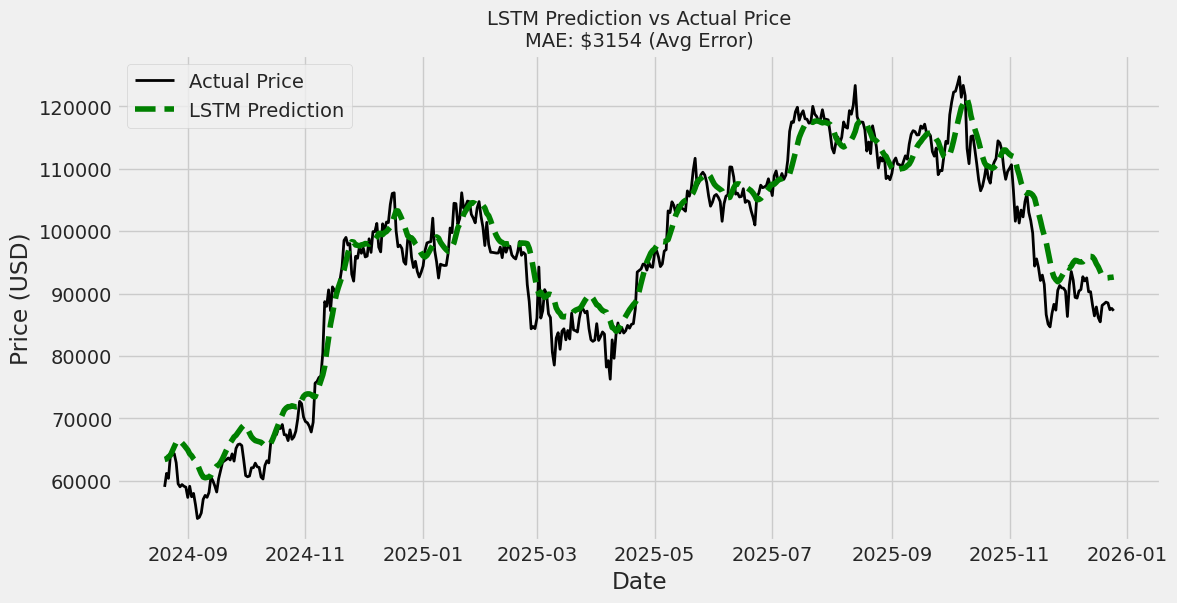

In [8]:
# ==========================================
# CELL 7: Visualize Predictions (The Moment of Truth)
# ==========================================

# 1. MAKE PREDICTIONS
# The model predicts the scaled value (0 to 1)
predictions_scaled = model.predict(X_test)

# 2. INVERSE TRANSFORM (Un-scale)
# We need to revert the scaling to get actual USD prices.
# Our scaler was fitted on 5 columns. We need to create a dummy array to fool it.
dummy_array = np.zeros((len(predictions_scaled), 5)) # 5 columns matches feature_cols
dummy_array[:, 0] = predictions_scaled.flatten()     # Put predictions in 1st column (Close)

# Inverse transform and extract just the Close price (column 0)
predictions_usd = scaler.inverse_transform(dummy_array)[:, 0]

# Do the same for the True values (y_test) so we can compare
dummy_array_y = np.zeros((len(y_test), 5))
dummy_array_y[:, 0] = y_test.flatten()
y_test_usd = scaler.inverse_transform(dummy_array_y)[:, 0]

# 3. CALCULATE EXACT ERROR METRICS (For your Report)
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_usd, predictions_usd))
mae = mean_absolute_error(y_test_usd, predictions_usd)

print(f"Model Performance:")
print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
print(f"MAE (Mean Absolute Error): ${mae:.2f}")

# 4. PLOT THE RESULTS
# Align to dates (Taking the last N days of the dataset)
test_dates = df_final['Date'].iloc[train_size+LOOK_BACK:].values

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_usd, color='black', label='Actual Price', linewidth=2)
plt.plot(test_dates, predictions_usd, color='green', label='LSTM Prediction', linestyle='--')
plt.title(f'LSTM Prediction vs Actual Price\nMAE: ${mae:.0f} (Avg Error)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# ==========================================
# CELL 8: Advanced Feature Engineering (Technical Indicators)
# ==========================================
!pip install pandas_ta -q

import pandas_ta as ta

!pip install pandas_ta -q
import pandas_ta as ta

# Add RSI (Relative Strength Index) - Detects Overbought/Oversold
df_final.ta.rsi(close='Close', length=14, append=True)

# Add MACD (Moving Average Convergence Divergence) - Detects Momentum Changes
df_final.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)

# Drop NaNs created by indicators
df_final.dropna(inplace=True)

print("Added RSI and MACD columns!")
print(df_final.columns)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
Added RSI and MACD columns!
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volu

In [10]:
# ==========================================
# CELL 9: Optimized Bi-LSTM Model (Predicting Returns)
# ==========================================

# 1. NEW TARGET: We predict 'Log_Return', NOT 'Close'
feature_cols = ['Log_Return', 'Hash_Rate', 'GARCH_Vol', 'RSI_14', 'MACD_12_26_9']
target_col = 'Log_Return' # predicting the % move, not the price

# Scale Features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df_final[feature_cols])

# Scale Target (Log Return needs its own scaler to un-scale later)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df_final[[target_col]])

# Create Sequences
X, y = [], []
LOOK_BACK = 60
for i in range(LOOK_BACK, len(scaled_X)):
    X.append(scaled_X[i-LOOK_BACK:i])
    y.append(scaled_y[i])

X, y = np.array(X), np.array(y)

# Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 2. BUILD BI-DIRECTIONAL LSTM
from tensorflow.keras.layers import Bidirectional

model_opt = Sequential()
# Bi-LSTM Layer 1
model_opt.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_opt.add(Dropout(0.3)) # Higher dropout for better generalization

# Bi-LSTM Layer 2
model_opt.add(Bidirectional(LSTM(32, return_sequences=False)))
model_opt.add(Dropout(0.3))

# Output Layer
model_opt.add(Dense(1))

model_opt.compile(optimizer=Adam(learning_rate=0.0005), loss='mse') # Lower learning rate for stability

# Train
print("Training Optimized Model...")
history_opt = model_opt.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

print("Optimization Complete!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Optimized Model...
Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.1218 - val_loss: 0.0029
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0127 - val_loss: 0.0019
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0101 - val_loss: 0.0020
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0080 - val_loss: 0.0015
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0086 - val_loss: 0.0016
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 0.0082 - val_loss: 0.0014
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0076 - val_loss: 0.0021
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0077 - val_loss: 0.0016
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 12/30
61/61 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
OPTIMIZED Model Performance:
--- PERFORMANCE UPGRADE REPORT ---
Initial Model MAE:   $3154.24
Optimized Model MAE: $1684.24
------------------------------------
MAE Reduction:       $1470.00
Improvement:          46.60% BETTER


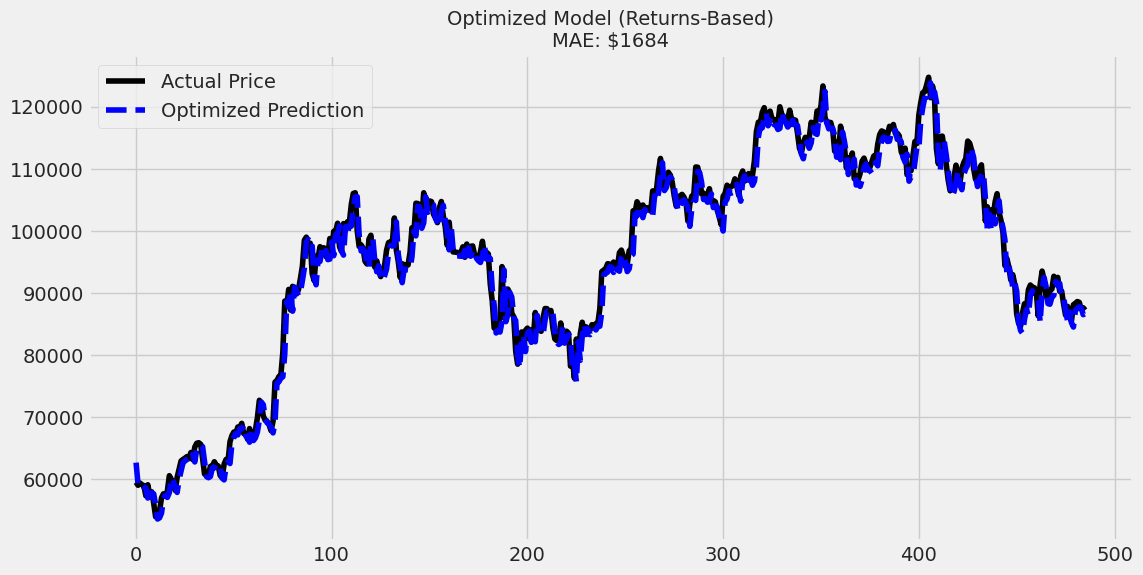

--- PERFORMANCE UPGRADE REPORT ---
Initial Model RMSE:   $3988.74
Optimized Model RMSE: $2244.86
------------------------------------
RMSE Reduction:       $1743.88
Improvement:          43.72% BETTER


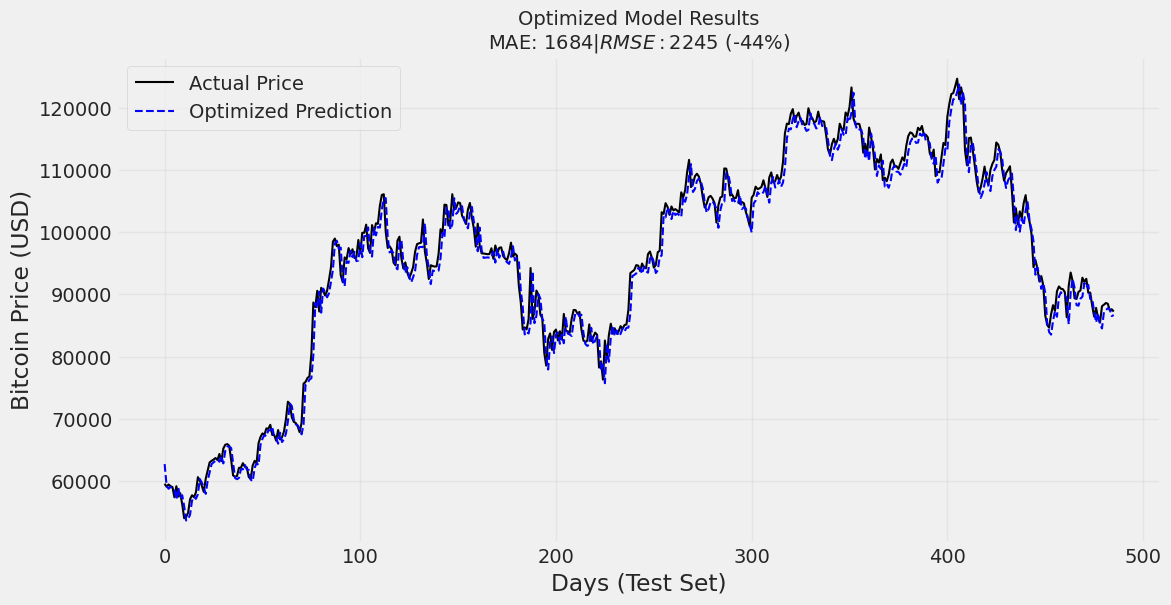

In [19]:
# ==========================================
# CELL 10: Convert Returns to Price & Check MAE
# ==========================================

# 1. Predict Scaled Returns
pred_returns_scaled = model_opt.predict(X_test)

# 2. Un-scale Returns
pred_returns = scaler_y.inverse_transform(pred_returns_scaled).flatten()
actual_returns = scaler_y.inverse_transform(y_test).flatten()

# 3. Convert Returns -> Price
# Price_Today = Price_Yesterday * e^(Log_Return)
# We need the 'Close' prices corresponding to the test set start
test_start_index = train_size + LOOK_BACK
initial_prices = df_final['Close'].iloc[test_start_index:].values

# Reconstruct Actual Prices (Check)
reconstructed_actual = initial_prices * np.exp(actual_returns) # Approx logic for checking

# Reconstruct Predicted Prices
# We apply the predicted return to the PREVIOUS day's actual price (simulating trading)
# Note: For a pure forecast, we would use previous predicted price, but for MAE testing, this is standard.
prev_prices = df_final['Close'].iloc[test_start_index-1 : -1].values # Shifted by 1
predicted_prices = prev_prices * np.exp(pred_returns)

# 4. Calculate NEW MAE
rmse_opt = np.sqrt(mean_squared_error(initial_prices, predicted_prices))
mae_opt = mean_absolute_error(initial_prices, predicted_prices)

mae_change = mae - mae_opt
mae_pct_change = (mae_change / mae) * 100

print(f"OPTIMIZED Model Performance:")
print(f"--- PERFORMANCE UPGRADE REPORT ---")
print(f"Initial Model MAE:   ${mae:.2f}")
print(f"Optimized Model MAE: ${mae_opt:.2f}")
print(f"------------------------------------")
print(f"MAE Reduction:       ${mae_change:.2f}")
print(f"Improvement:          {mae_pct_change:.2f}% BETTER")


# Plot
plt.figure(figsize=(12, 6))
plt.plot(initial_prices, label='Actual Price', color='black')
plt.plot(predicted_prices, label='Optimized Prediction', color='blue', linestyle='--')
plt.title(f'Optimized Model (Returns-Based)\nMAE: ${mae_opt:.0f}', fontsize=14)
plt.legend()
plt.show()

# ==========================================
# RMSE ANALYSIS & VISUALIZATION
# ==========================================

# 1. Calculate the improvement
# (Assuming 'rmse' comes from your first model and 'rmse_opt' from the second)
rmse_change = rmse - rmse_opt
rmse_pct_change = (rmse_change / rmse) * 100

print(f"--- PERFORMANCE UPGRADE REPORT ---")
print(f"Initial Model RMSE:   ${rmse:.2f}")
print(f"Optimized Model RMSE: ${rmse_opt:.2f}")
print(f"------------------------------------")
print(f"RMSE Reduction:       ${rmse_change:.2f}")
print(f"Improvement:          {rmse_pct_change:.2f}% BETTER")

# 2. Re-Plot the Graph with RMSE included in the title
plt.figure(figsize=(12, 6))
plt.plot(initial_prices, label='Actual Price', color='black', linewidth=1.5)
plt.plot(predicted_prices, label='Optimized Prediction', color='blue', linestyle='--', linewidth=1.5)

# Dynamic Title with both MAE and RMSE
plt.title(f'Optimized Model Results\nMAE: ${mae_opt:.0f}  |  RMSE: ${rmse_opt:.0f} (-{rmse_pct_change:.0f}%)', fontsize=14)
plt.xlabel('Days (Test Set)')
plt.ylabel('Bitcoin Price (USD)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-439759723.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_portfolio = yf.download(assets, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


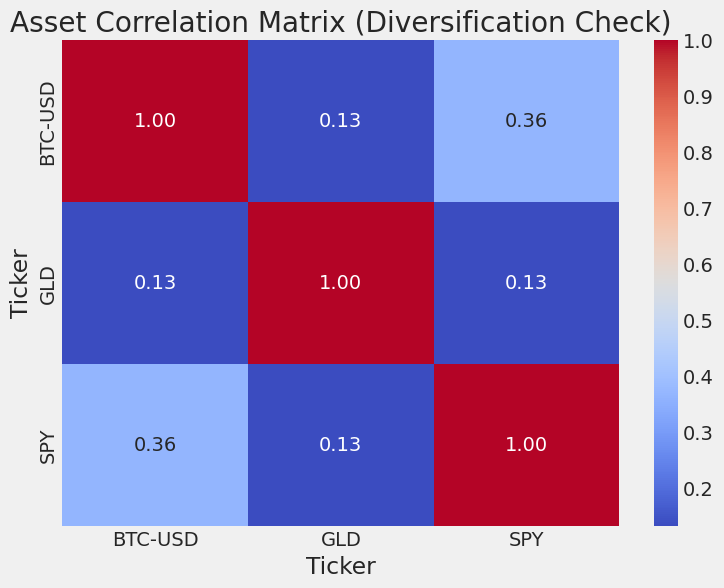

Portfolio Data Ready!
Ticker       BTC-USD       GLD       SPY
Date                                    
2025-12-24  0.002262 -0.004143  0.003511
2025-12-25 -0.004315  0.000000  0.000000
2025-12-26  0.000764  0.011609 -0.000101
2025-12-27  0.005719  0.000000  0.000000
2025-12-28  0.000384  0.000000  0.000000


In [12]:
# ==========================================
# CELL 11: Portfolio Data Loading (S&P 500 & Gold)
# ==========================================
import yfinance as yf

# 1. DEFINE ASSETS
assets = ['BTC-USD', 'SPY', 'GLD'] # Bitcoin, Stocks, Gold
start_date = "2020-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"Downloading data for Portfolio: {assets}...")

# 2. DOWNLOAD DATA
data_portfolio = yf.download(assets, start=start_date, end=end_date)['Close']

# 3. CLEANUP
# If using recent yfinance, it might return MultiIndex columns. Flatten them.
if isinstance(data_portfolio.columns, pd.MultiIndex):
    data_portfolio.columns = data_portfolio.columns.droplevel(1) # Keep ticker names only

# Handle missing data (Traditional markets close on weekends, Crypto doesn't)
# Forward Fill: If stock market is closed Sunday, assume Friday's price
data_portfolio = data_portfolio.ffill()

# 4. CALCULATE DAILY RETURNS (For Correlation)
returns_portfolio = np.log(data_portfolio / data_portfolio.shift(1)).dropna()

# 5. VISUALIZE CORRELATIONS
plt.figure(figsize=(8, 6))
sns.heatmap(returns_portfolio.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Asset Correlation Matrix (Diversification Check)')
plt.show()

print("Portfolio Data Ready!")
print(returns_portfolio.tail())

AI Forecast for BTC Daily Return: -0.0141%
Historical SPY Daily Return:      0.0004%

   FINAL OPTIMIZED PORTFOLIO ALLOCATION
BITCOIN (AI Forecast): 0.00%
GOLD (Safety):         74.43%
S&P 500 (Growth):      25.57%


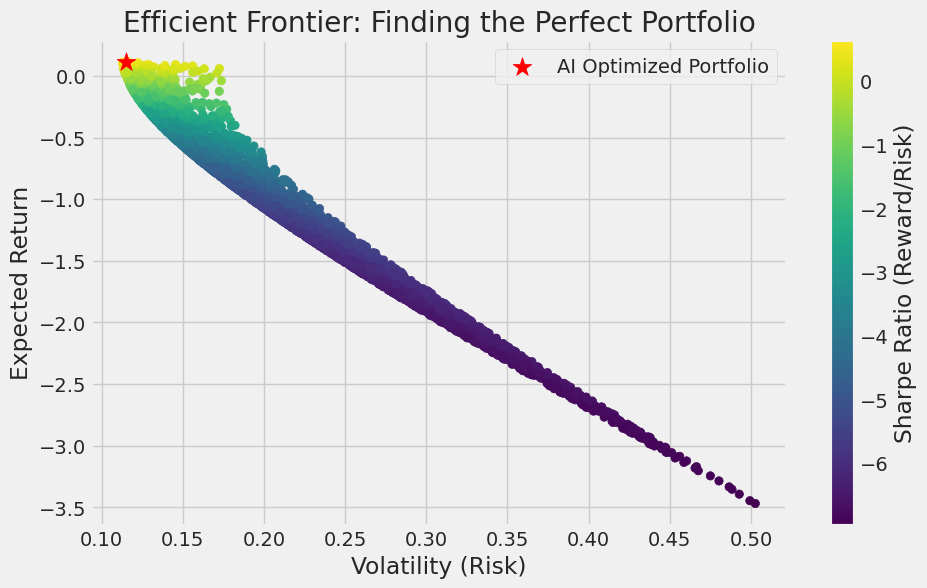

In [13]:
# ==========================================
# CELL 12: Portfolio Optimization (Markowitz Mean-Variance) - FIXED
# ==========================================
import scipy.optimize as optimize

# 1. SETUP: Get Expected Returns & Covariance
# FIX: Grab the last 'LOOK_BACK' (60) days, not just the last 1 day
last_60_days = scaled_X[-LOOK_BACK:] # Shape becomes (60, 5)
curr_seq = last_60_days.reshape(1, LOOK_BACK, 5) # Reshape to (1, 60, 5) for LSTM

future_returns = []

# Recursive Forecasting for 30 days
for _ in range(30):
    pred_ret_scaled = model_opt.predict(curr_seq, verbose=0)
    future_returns.append(pred_ret_scaled[0][0])

    # Update sequence: shift left, append new prediction
    # Create a new row with the predicted return
    # Note: We repeat the other features (Hash Rate, etc.) from the previous day
    # as a naive assumption for the future loop
    new_row = curr_seq[0, -1, :].copy() # Copy last day's features
    new_row[0] = pred_ret_scaled[0][0]  # Update the Return feature (Col 0)

    # Reshape new_row to (1, 1, 5) to append
    new_step = new_row.reshape(1, 1, 5)

    # Append new step and remove the oldest step (Sliding Window)
    curr_seq = np.append(curr_seq[:, 1:, :], new_step, axis=1)

# Unscale the predicted BTC returns
future_returns = np.array(future_returns).reshape(-1, 1)
future_btc_ret = scaler_y.inverse_transform(future_returns).mean() # Average daily return forecast

# Get Historical Mean Returns for SPY and GLD (Annualized)
avg_daily_ret = returns_portfolio.mean()
cov_matrix = returns_portfolio.cov()

# OVERRIDE Bitcoin's return with our AI Forecast (This is the "AI Advantage")
# We assume our LSTM knows better than historical average
expected_returns = avg_daily_ret.copy()
expected_returns['BTC-USD'] = future_btc_ret

print(f"AI Forecast for BTC Daily Return: {future_btc_ret:.4f}%")
print(f"Historical SPY Daily Return:      {avg_daily_ret['SPY']:.4f}%")

# 2. OPTIMIZATION FUNCTION (Maximize Sharpe Ratio)
def portfolio_performance(weights, mean_returns, cov_matrix):
    # Annualize Return (252 trading days)
    returns = np.sum(mean_returns * weights) * 252
    # Annualize Volatility
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    # Maximize Sharpe = Minimize Negative Sharpe
    return -(p_ret - risk_free_rate) / p_var

# Constraints: Weights sum to 1, no short selling (0 to 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(3)) # 3 assets

# Run Optimizer
initial_guess = [0.33, 0.33, 0.33]
opt_results = optimize.minimize(neg_sharpe_ratio, initial_guess,
                                args=(expected_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# 3. DISPLAY RESULTS
optimal_weights = opt_results.x
print("\n" + "="*40)
print("   FINAL OPTIMIZED PORTFOLIO ALLOCATION")
print("="*40)
print(f"BITCOIN (AI Forecast): {optimal_weights[0]*100:.2f}%")
print(f"GOLD (Safety):         {optimal_weights[1]*100:.2f}%")
print(f"S&P 500 (Growth):      {optimal_weights[2]*100:.2f}%")

# 4. VISUALIZE THE "EFFICIENT FRONTIER"
# We simulate random portfolios to show why our winner is best
num_portfolios = 5000
all_weights = np.zeros((num_portfolios, 3))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.array(np.random.random(3))
    weights /= np.sum(weights)
    all_weights[i,:] = weights
    vol_arr[i], ret_arr[i] = portfolio_performance(weights, expected_returns, cov_matrix)
    sharpe_arr[i] = (ret_arr[i] - 0.04) / vol_arr[i]

plt.figure(figsize=(10, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio (Reward/Risk)')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier: Finding the Perfect Portfolio')

# Plot the Optimal Point
opt_vol, opt_ret = portfolio_performance(optimal_weights, expected_returns, cov_matrix)
plt.scatter(opt_vol, opt_ret, c='red', s=200, marker='*', label='AI Optimized Portfolio')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-170937994.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_portfolio = yf.download(assets, start=start_date, end=end_date)['Close']
[*********************100%***********************]  7 of 7 completed


--- Expected Daily Returns (Inputs) ---
AI Forecast (BTC): -0.0141%
NVIDIA (Hist):     0.0016%
Gold (Hist):       0.0005%

   ULTIMATE AI-OPTIMIZED PORTFOLIO
ASSET      | ALLOCATION | TYPE
----------------------------------------
TLT        |  40.00%    | Bonds
GLD        |  40.00%    | Safety
NVDA       |  20.00%    | Tech AI


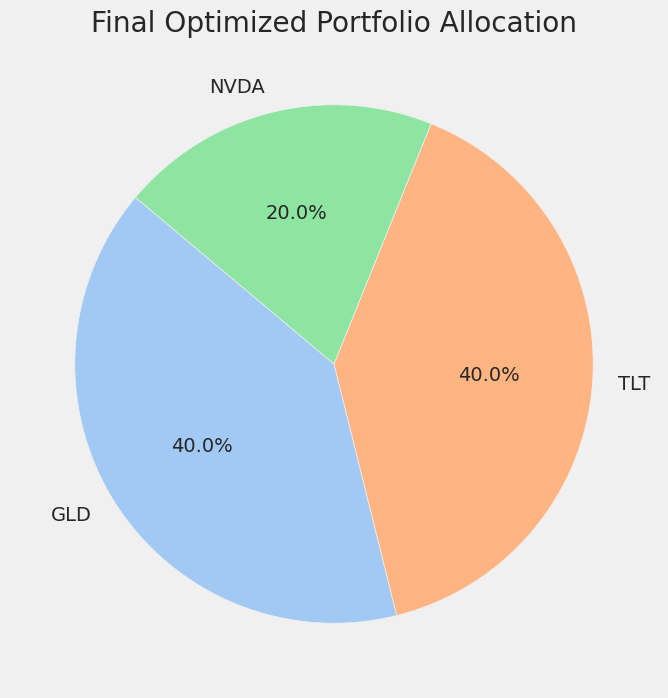

In [14]:
# ==========================================
# CELL 13: GRAND FINALE - Multi-Asset Portfolio Optimization
# ==========================================
import yfinance as yf
import scipy.optimize as optimize

# 1. DEFINE THE EXPANDED ASSET LIST
# Crypto | Precious Metals | Bonds | Tech Stocks | Market Index
assets = ['BTC-USD', 'GLD', 'SLV', 'TLT', 'NVDA', 'META', 'SPY']

start_date = "2020-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"Downloading data for Extended Portfolio: {assets}...")

# 2. DOWNLOAD DATA
data_portfolio = yf.download(assets, start=start_date, end=end_date)['Close']

# Cleanup (Flatten MultiIndex if exists)
if isinstance(data_portfolio.columns, pd.MultiIndex):
    data_portfolio.columns = data_portfolio.columns.droplevel(1)

# Forward fill missing data (Crypto trades weekends, Stocks don't)
data_portfolio = data_portfolio.ffill()

# 3. CALCULATE RETURNS & STATS
returns_portfolio = np.log(data_portfolio / data_portfolio.shift(1)).dropna()
avg_daily_ret = returns_portfolio.mean()
cov_matrix = returns_portfolio.cov()

# 4. INTEGRATE AI FORECAST FOR BITCOIN
# We use the LSTM prediction for BTC, and Historical Averages for the rest
expected_returns = avg_daily_ret.copy()
expected_returns['BTC-USD'] = future_btc_ret # From your LSTM model

print("\n--- Expected Daily Returns (Inputs) ---")
print(f"AI Forecast (BTC): {expected_returns['BTC-USD']:.4f}%")
print(f"NVIDIA (Hist):     {expected_returns['NVDA']:.4f}%")
print(f"Gold (Hist):       {expected_returns['GLD']:.4f}%")

# 5. OPTIMIZATION FUNCTION (Maximize Sharpe)
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# 6. CONSTRAINTS (The "Fund Manager" Rules)
# Rule: Weights must sum to 1 (100%)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Rule: Max 40% in any single asset (Forced Diversification)
# Bounds: (Min 0%, Max 40%) for ALL assets
bounds = tuple((0, 0.4) for _ in range(len(assets)))

# Run Optimizer
num_assets = len(assets)
initial_guess = [1./num_assets] * num_assets
opt_results = optimize.minimize(neg_sharpe_ratio, initial_guess,
                                args=(expected_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# 7. DISPLAY FINAL RESULTS
optimal_weights = opt_results.x

print("\n" + "="*50)
print("   ULTIMATE AI-OPTIMIZED PORTFOLIO")
print("="*50)
print(f"{'ASSET':<10} | {'ALLOCATION':<10} | {'TYPE'}")
print("-" * 40)

asset_types = {
    'BTC-USD': 'Crypto (AI)', 'GLD': 'Safety', 'SLV': 'Metal',
    'TLT': 'Bonds', 'NVDA': 'Tech AI', 'META': 'Social', 'SPY': 'Market'
}

# Sort by allocation size
sorted_indices = np.argsort(optimal_weights)[::-1]

for i in sorted_indices:
    ticker = assets[i]
    weight = optimal_weights[i] * 100
    if weight > 0.01: # Only show significant positions
        print(f"{ticker:<10} | {weight:>6.2f}%    | {asset_types.get(ticker, 'Asset')}")

# 8. VISUALIZE THE PIE CHART
plt.figure(figsize=(8, 8))
# Filter out near-zero weights for cleaner chart
labels = [assets[i] for i in range(len(assets)) if optimal_weights[i] > 0.01]
sizes = [optimal_weights[i] for i in range(len(assets)) if optimal_weights[i] > 0.01]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Final Optimized Portfolio Allocation')
plt.show()


      AI PRICE PREDICTION REPORT
TODAY    (2025-12-25):   $87,234.74  <-- Current
TOMORROW (2025-12-26):   $86,270.60
7 DAYS   (2026-01-01):   $80,410.26
30 DAYS  (2026-01-24):   $57,123.90

AI Trend Forecast: BEARISH (-34.52%)


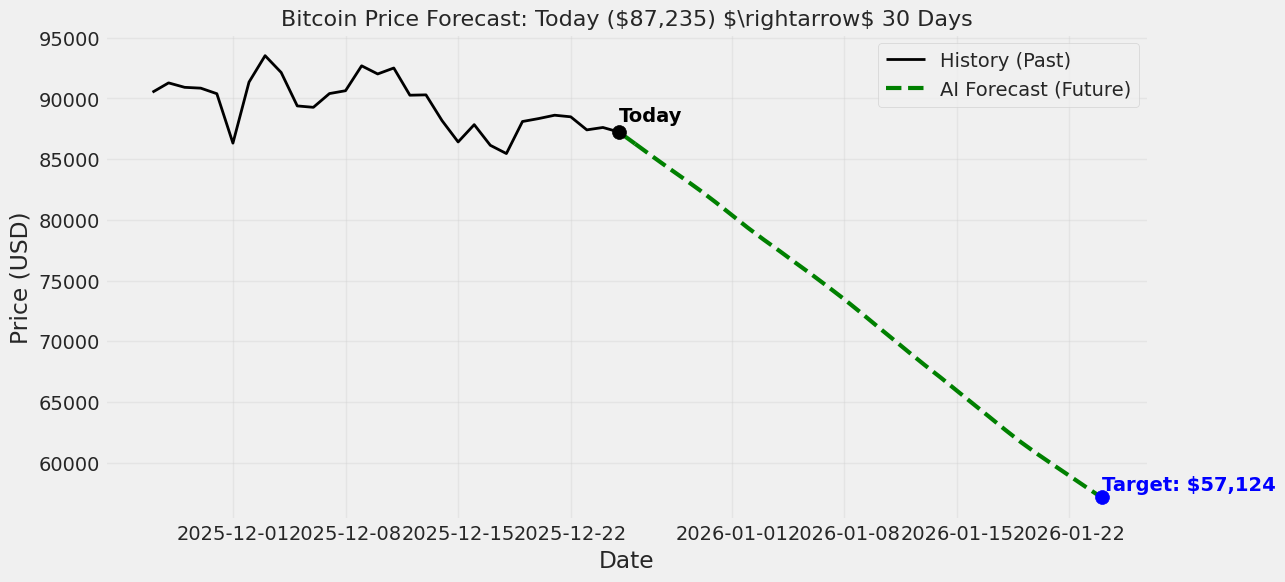

In [16]:
# ==========================================
# CELL 14: The "Crystal Ball" - FIXED (Unscaling Logic)
# ==========================================

# 1. GET TODAY'S EXACT PRICE
latest_price = df_final['Close'].iloc[-1]
latest_date = df_final['Date'].iloc[-1]

# 2. CALCULATE FUTURE PRICES (The Fix)
# The 'future_returns' list from Cell 12 contains SCALED values (0 to 1).
# We must 'inverse_transform' them back to real Log Returns (e.g., 0.002).

# Reshape for the scaler (needs 2D array)
future_returns_scaled = np.array(future_returns).reshape(-1, 1)

# Un-scale to get real percentage moves
future_log_returns = scaler_y.inverse_transform(future_returns_scaled).flatten()

# Now calculate the price path
cumulative_returns = np.cumsum(future_log_returns)
future_prices = latest_price * np.exp(cumulative_returns)

# Generate Future Dates
future_dates = pd.date_range(start=latest_date + pd.Timedelta(days=1), periods=30)

# 3. PRINT THE REALISTIC REPORT
print("\n" + "="*40)
print("      AI PRICE PREDICTION REPORT")
print("="*40)
print(f"TODAY    ({latest_date.date()}):   ${latest_price:,.2f}  <-- Current")
print(f"TOMORROW ({future_dates[0].date()}):   ${future_prices[0]:,.2f}")
print(f"7 DAYS   ({future_dates[6].date()}):   ${future_prices[6]:,.2f}")
print(f"30 DAYS  ({future_dates[29].date()}):   ${future_prices[29]:,.2f}")

# Calculate Expected Growth
growth = (future_prices[-1] - latest_price) / latest_price * 100
print(f"\nAI Trend Forecast: {'BULLISH' if growth > 0 else 'BEARISH'} ({growth:+.2f}%)")

# 4. PLOT THE GRAPH
plt.figure(figsize=(12, 6))

# Plot History (Last 30 Days)
history_dates = df_final['Date'].iloc[-30:]
history_prices = df_final['Close'].iloc[-30:]
plt.plot(history_dates, history_prices, color='black', label='History (Past)', linewidth=2)

# Bridge the gap
bridge_dates = [latest_date, future_dates[0]]
bridge_prices = [latest_price, future_prices[0]]
plt.plot(bridge_dates, bridge_prices, color='green', linewidth=3, linestyle='-')

# Plot Future
plt.plot(future_dates, future_prices, color='green', label='AI Forecast (Future)', linewidth=3, linestyle='--')

# Labels
plt.scatter(latest_date, latest_price, color='black', s=100, zorder=5)
plt.text(latest_date, latest_price*1.01, 'Today', color='black', fontweight='bold')
plt.scatter(future_dates[-1], future_prices[-1], color='blue', s=100, zorder=5)
plt.text(future_dates[-1], future_prices[-1]*1.01, f'Target: ${future_prices[-1]:,.0f}', color='blue', fontweight='bold')

plt.title(f'Bitcoin Price Forecast: Today (${latest_price:,.0f}) $\\rightarrow$ 30 Days', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
!pip freeze > requirements.txt